# Model Development

**Author:** Guilherme Cadori

**Date:** 14/05/2024


## Machine Learning Competitions

- Housing Prices Competition


**Introduction**

Machine learning competitions are a great way to improve your data science skills and measure your progress.

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to improve and see how you stack up to others taking this micro-course.

The steps in this notebook are:

    1) Build a Random Forest model with all of your data (X and y).

    2) Read in the "test" data, which doesn't include values for the target. Predict home values in the test data with your Random Forest model.

    3) Submit those predictions to the competition and see your score.

    4) Optionally, come back to see if you can improve your model by adding features or changing your model. Then you can resubmit to see how that stacks up on the competition leaderboard.


We will also expand on the original proposal and evaluate different model types, as outlined below.

Model types to be tested:
- Linear Regression
- Polynomial Regression
- Decision Tree
- Random Forest
- Neural Network
- Deep Neural Network
- Model Ensemble


Model Performance Metric:
- Mean Absolute Error (MAE)


### Importing Libraries

In [90]:
# Code you have previously used to load data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.ensemble import VotingRegressor

import optuna
from sklearn.model_selection import cross_val_score


### Loading and Splitting Data

In [2]:
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path)

# Create target object and call it y
y = home_data.SalePrice

# Create X
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


### Linear Regression

In [3]:
# Creating linear regression model
linear_model = LinearRegression()

# Training the model
linear_model.fit(train_X, train_y)

# Creating predictions
val_predictions = linear_model.predict(val_X)

# Calculating MAE
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.0f}".format(val_mae))


Validation MAE: 27,229


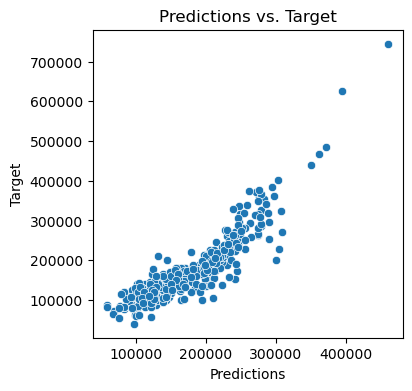

In [4]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


### Polynomial Regression

#### Investigating Features

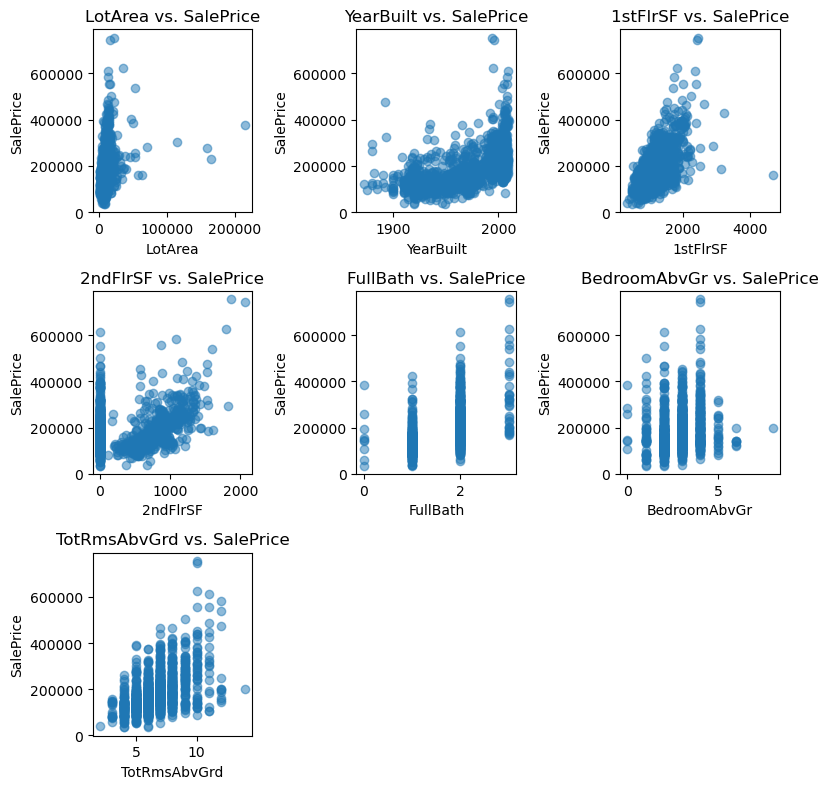

In [56]:
# Transforming features
# Will check for non-linear relationships before transforming
# Get the column names of X
feature_names = X.columns

# Set up the subplot grid
num_features = len(feature_names)
cols = 3  # Number of columns in the subplot grid
rows = (num_features + cols - 1) // cols  # Calculate the number of rows

# Create the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each feature
for i, feature in enumerate(feature_names):
    # Create a scatter plot
    axes[i].scatter(X[feature], y, alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('SalePrice')
    axes[i].set_title(f'{feature} vs. SalePrice')

# Hide unused subplots
for j in range(num_features, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Transforming Features

In [57]:
# Checkin X's columns names again
X.columns


Index(['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath',
       'BedroomAbvGr', 'TotRmsAbvGrd'],
      dtype='object')

##### Squared Features

In [58]:
# Select the columns for polynomial transformation
# Will tranform only 'YearBuilt' and '2ndFlrSF'
poly_features = ['YearBuilt', '2ndFlrSF']
X_transform = X[poly_features]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_array = poly.fit_transform(X_transform)

# Create a DataFrame for the polynomial features with custom column names
poly_feature_names = poly.get_feature_names_out(input_features=poly_features)
X_poly = pd.DataFrame(X_poly_array, columns=poly_feature_names)

# Checking transformed features
X_poly


,YearBuilt,2ndFlrSF,YearBuilt^2,YearBuilt 2ndFlrSF,2ndFlrSF^2
0,2003.0,854.0,4012009.0,1710562.0,729316.0
1,1976.0,0.0,3904576.0,0.0,0.0
2,2001.0,866.0,4004001.0,1732866.0,749956.0
3,1915.0,756.0,3667225.0,1447740.0,571536.0
4,2000.0,1053.0,4000000.0,2106000.0,1108809.0
...,...,...,...,...,...
1455,1999.0,694.0,3996001.0,1387306.0,481636.0
1456,1978.0,0.0,3912484.0,0.0,0.0
1457,1941.0,1152.0,3767481.0,2236032.0,1327104.0
1458,1950.0,0.0,3802500.0,0.0,0.0


In [59]:
# Adjusting the composition of the X object
cols_to_keep = ['LotArea', '1stFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X[cols_to_keep]

# Merging transformed features
X = pd.concat([X, X_poly], axis=1)

# Checking feature set
X


,LotArea,1stFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,YearBuilt,2ndFlrSF,YearBuilt^2,YearBuilt 2ndFlrSF,2ndFlrSF^2
0,8450,856,2,3,8,2003.0,854.0,4012009.0,1710562.0,729316.0
1,9600,1262,2,3,6,1976.0,0.0,3904576.0,0.0,0.0
2,11250,920,2,3,6,2001.0,866.0,4004001.0,1732866.0,749956.0
3,9550,961,1,3,7,1915.0,756.0,3667225.0,1447740.0,571536.0
4,14260,1145,2,4,9,2000.0,1053.0,4000000.0,2106000.0,1108809.0
...,...,...,...,...,...,...,...,...,...,...
1455,7917,953,2,3,7,1999.0,694.0,3996001.0,1387306.0,481636.0
1456,13175,2073,2,3,7,1978.0,0.0,3912484.0,0.0,0.0
1457,9042,1188,2,4,9,1941.0,1152.0,3767481.0,2236032.0,1327104.0
1458,9717,1078,1,2,5,1950.0,0.0,3802500.0,0.0,0.0


In [60]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


In [61]:
# Creating model
polyReg_model = LinearRegression()

# Training model
polyReg_model.fit(train_X, train_y)

# Creating predictions
val_predictions = polyReg_model.predict(val_X)

# Calculating MAE
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.0f}".format(val_mae))


Validation MAE: 25,959


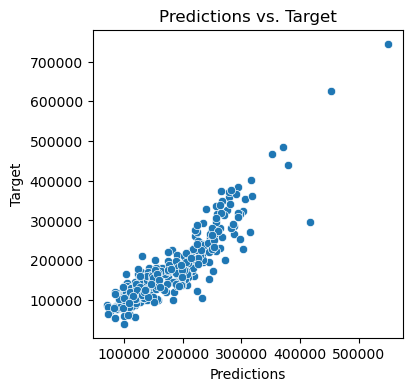

In [62]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


##### Re-importing Original Features

In [63]:
# Creating original data split and removing transfomed features
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path)

# Create target object and call it y
y = home_data.SalePrice
# Create X
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


##### Square Root Features

In [64]:
# Select the columns for square root transformation
sqrt_features = ['YearBuilt', '2ndFlrSF']
X_transform = X[sqrt_features]

# Create square root features
X_sqrt = np.sqrt(X_transform)

# Create a DataFrame for the square root features with custom column names
sqrt_feature_names = [f'sqrt_{feature}' for feature in sqrt_features]
X_sqrt.columns = sqrt_feature_names

# Adjusting the composition of the X object
cols_to_keep = ['LotArea', '1stFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X[cols_to_keep]

# Merging square root features
X = pd.concat([X, X_sqrt], axis=1)

# Checking feature set
X


,LotArea,1stFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,sqrt_YearBuilt,sqrt_2ndFlrSF
0,8450,856,2,3,8,44.754888,29.223278
1,9600,1262,2,3,6,44.452222,0.000000
2,11250,920,2,3,6,44.732538,29.427878
3,9550,961,1,3,7,43.760713,27.495454
4,14260,1145,2,4,9,44.721360,32.449961
...,...,...,...,...,...,...,...
1455,7917,953,2,3,7,44.710178,26.343880
1456,13175,2073,2,3,7,44.474712,0.000000
1457,9042,1188,2,4,9,44.056782,33.941125
1458,9717,1078,1,2,5,44.158804,0.000000


In [65]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


In [66]:
# Creating model
polyReg_model = LinearRegression()

# Training model
polyReg_model.fit(train_X, train_y)

# Creating predictions
val_predictions = polyReg_model.predict(val_X)

# Calculating MAE
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.0f}".format(val_mae))


Validation MAE: 28,495


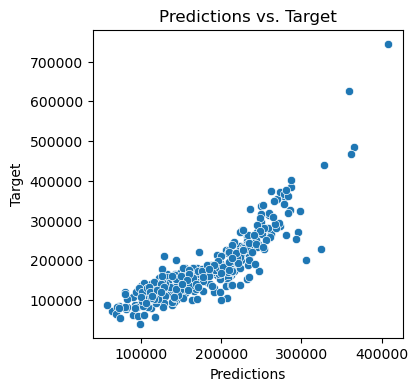

In [67]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


##### Re-importing Original Features

In [68]:
# Creating original data split and removing transfomed features
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path)

# Create target object and call it y
y = home_data.SalePrice
# Create X
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


### Decision Tree

In [69]:
# Specify Model
decisionTree_model = DecisionTreeRegressor(random_state=1)
# Fit Model
decisionTree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = decisionTree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

# Using best value for max_leaf_nodes
decisionTree_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
decisionTree_model.fit(train_X, train_y)
val_predictions = decisionTree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))


Validation MAE when not specifying max_leaf_nodes: 29,653
Validation MAE for best value of max_leaf_nodes: 27,283


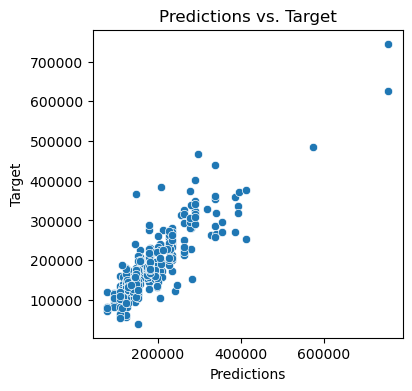

In [70]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


### Random Forest

In [71]:
# Define the model. Set random_state to 1
randomForest_model = RandomForestRegressor(random_state=1)
randomForest_model.fit(train_X, train_y)
rf_val_predictions = randomForest_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))


Validation MAE for Random Forest Model: 21,857


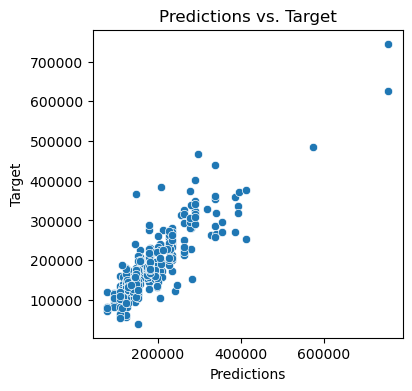

In [72]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


### Neural Network

In [73]:
# Creating model
nn_model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Training model
nn_model.fit(train_X, train_y, epochs=10, batch_size=16, validation_data=(val_X, val_y))

loss = nn_model.evaluate(val_X, val_y)

print(f"Test Loss: {loss}")


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 37049798656.0000 - val_loss: 33674184704.0000
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32968257536.0000 - val_loss: 26215041024.0000
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25826955264.0000 - val_loss: 16922790912.0000
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14191010816.0000 - val_loss: 13627596800.0000
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13427735552.0000 - val_loss: 12580566016.0000
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13430643712.0000 - val_loss: 11802807296.0000
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9769807872.0000 - val_loss: 11212936192.0000
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9815602176.0000 - val_loss: 10628966400.0000
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11197257728.0000 - val_loss: 10068654080.0000
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1763893

In [74]:
# Creating predictions
val_predictions = nn_model.predict(val_X)

# Calculating MAE
val_mae = mean_absolute_error(val_predictions, val_y)

print("Validation MAE: {:,.0f}".format(val_mae))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation MAE: 55,387


In [75]:
# Reshaping val_predictions
val_predictions = val_predictions.reshape(-1)


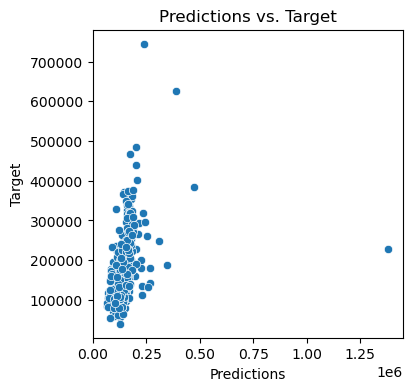

In [76]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


### Deep Neural Network

In [77]:
# Define the model
dnn_model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

dnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
dnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Train the model
dnn_model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(val_X, val_y))

# Evaluate the model
loss = dnn_model.evaluate(val_X, val_y)
print(f"Test Loss: {loss}")


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 39904354304.0000 - val_loss: 35621318656.0000
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35432194048.0000 - val_loss: 26530037760.0000
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23103035392.0000 - val_loss: 14509558784.0000
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12120188928.0000 - val_loss: 13247920128.0000
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9581639680.0000 - val_loss: 12029999104.0000
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10018522112.0000 - val_loss: 11050332160.0000
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15207628800.0000 - val_loss: 9792868352.0000
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9232377856.0000 - val_loss: 8925693952.0000
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8522626560.0000 - val_loss: 8148439552.0000
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10561215488

In [79]:
# Make predictions
val_predictions = dnn_model.predict(val_X)

# Calculate MAE
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.0f}".format(val_mae))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Validation MAE: 48,438


### Random Forest with Engineered Features

#### Feature Transformation

##### Squared Features

In [80]:
# Select the columns for polynomial transformation
# Will tranform only 'YearBuilt' and '2ndFlrSF'
poly_features = ['YearBuilt', '2ndFlrSF']
X_transform = X[poly_features]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_array = poly.fit_transform(X_transform)

# Create a DataFrame for the polynomial features with custom column names
poly_feature_names = poly.get_feature_names_out(input_features=poly_features)
X_poly = pd.DataFrame(X_poly_array, columns=poly_feature_names)

# Adjusting the composition of the X object
cols_to_keep = ['LotArea', '1stFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X_squared = X[cols_to_keep]

# Merging transformed features
X_squared = pd.concat([X, X_poly], axis=1)

# Checking feature set
X_squared


,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,YearBuilt,2ndFlrSF,YearBuilt^2,YearBuilt 2ndFlrSF,2ndFlrSF^2
0,8450,2003,856,854,2,3,8,2003.0,854.0,4012009.0,1710562.0,729316.0
1,9600,1976,1262,0,2,3,6,1976.0,0.0,3904576.0,0.0,0.0
2,11250,2001,920,866,2,3,6,2001.0,866.0,4004001.0,1732866.0,749956.0
3,9550,1915,961,756,1,3,7,1915.0,756.0,3667225.0,1447740.0,571536.0
4,14260,2000,1145,1053,2,4,9,2000.0,1053.0,4000000.0,2106000.0,1108809.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,1999,953,694,2,3,7,1999.0,694.0,3996001.0,1387306.0,481636.0
1456,13175,1978,2073,0,2,3,7,1978.0,0.0,3912484.0,0.0,0.0
1457,9042,1941,1188,1152,2,4,9,1941.0,1152.0,3767481.0,2236032.0,1327104.0
1458,9717,1950,1078,0,1,2,5,1950.0,0.0,3802500.0,0.0,0.0


##### Square Root Features

In [81]:
# Select the columns for square root transformation
sqrt_features = ['YearBuilt', '2ndFlrSF']
X_transform = X[sqrt_features]

# Create square root features
X_sqrt = np.sqrt(X_transform)

# Create a DataFrame for the square root features with custom column names
sqrt_feature_names = [f'sqrt_{feature}' for feature in sqrt_features]
X_sqrt.columns = sqrt_feature_names

# Checking feature set
X_sqrt


,sqrt_YearBuilt,sqrt_2ndFlrSF
0,44.754888,29.223278
1,44.452222,0.000000
2,44.732538,29.427878
3,43.760713,27.495454
4,44.721360,32.449961
...,...,...
1455,44.710178,26.343880
1456,44.474712,0.000000
1457,44.056782,33.941125
1458,44.158804,0.000000


##### Concatenating Additional Features

In [82]:
# Merging square root features
X_all = pd.concat([X_squared, X_sqrt], axis=1)

# # Adjusting featurs to keep
X_all = X_all.drop(X_all.columns[8], axis=1)

# Checking feature set
X_all


,LotArea,YearBuilt,1stFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,YearBuilt,YearBuilt^2,YearBuilt 2ndFlrSF,2ndFlrSF^2,sqrt_YearBuilt,sqrt_2ndFlrSF
0,8450,2003,856,2,3,8,2003.0,4012009.0,1710562.0,729316.0,44.754888,29.223278
1,9600,1976,1262,2,3,6,1976.0,3904576.0,0.0,0.0,44.452222,0.000000
2,11250,2001,920,2,3,6,2001.0,4004001.0,1732866.0,749956.0,44.732538,29.427878
3,9550,1915,961,1,3,7,1915.0,3667225.0,1447740.0,571536.0,43.760713,27.495454
4,14260,2000,1145,2,4,9,2000.0,4000000.0,2106000.0,1108809.0,44.721360,32.449961
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,1999,953,2,3,7,1999.0,3996001.0,1387306.0,481636.0,44.710178,26.343880
1456,13175,1978,2073,2,3,7,1978.0,3912484.0,0.0,0.0,44.474712,0.000000
1457,9042,1941,1188,2,4,9,1941.0,3767481.0,2236032.0,1327104.0,44.056782,33.941125
1458,9717,1950,1078,1,2,5,1950.0,3802500.0,0.0,0.0,44.158804,0.000000


#### Creating split datasets

In [83]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X_all, y, random_state=1)


#### Predictions

In [84]:
# Define the model. Set random_state to 1
randomForest_model_featEng = RandomForestRegressor(random_state=1)
randomForest_model_featEng.fit(train_X, train_y)
rf_val_predictions = randomForest_model_featEng.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))


Validation MAE for Random Forest Model: 21,952


#### Hyperparameter Tuning

In [91]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

    model = RandomForestRegressor(**params, random_state=1)
    return -np.mean(cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error'))


In [93]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=1)
best_model.fit(train_X, train_y)
val_predictions = best_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)

print("Validation MAE: {:,.0f}".format(val_mae))
print("Best Parameters:", best_params)


[I 2024-05-15 01:06:15,635] A new study created in memory with name: no-name-2fdb8b02-ed5b-46e4-91d0-7b0025721828
[I 2024-05-15 01:06:21,836] Trial 0 finished with value: 26352.564902991126 and parameters: {'n_estimators': 851, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 0 with value: 26352.564902991126.
[I 2024-05-15 01:06:27,040] Trial 1 finished with value: 24877.884594352516 and parameters: {'n_estimators': 568, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 24877.884594352516.
[I 2024-05-15 01:06:34,466] Trial 2 finished with value: 24887.866472119887 and parameters: {'n_estimators': 857, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 24877.884594352516.
[I 2024-05-15 01:06:41,055] Trial 3 finished with value: 26835.00072778513 and parameters: {'n_estimators': 825, 'max_depth': 7, 'm

[I 2024-05-15 01:11:15,058] Trial 33 finished with value: 23269.69569139051 and parameters: {'n_estimators': 465, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'auto'}. Best is trial 23 with value: 22787.16493438201.
[I 2024-05-15 01:11:28,338] Trial 34 finished with value: 22808.659987263265 and parameters: {'n_estimators': 559, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 23 with value: 22787.16493438201.
[I 2024-05-15 01:11:33,720] Trial 35 finished with value: 24202.95545866337 and parameters: {'n_estimators': 559, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 23 with value: 22787.16493438201.
[I 2024-05-15 01:11:37,164] Trial 36 finished with value: 25101.077397333727 and parameters: {'n_estimators': 348, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 23 with value: 22787.164934

Validation MAE: 21,998
Best Parameters: {'n_estimators': 764, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'auto'}


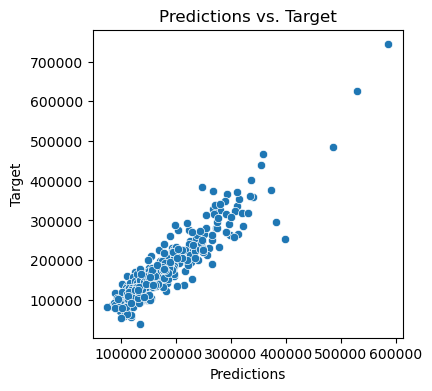

In [94]:
# Creating scatter plot for validation dataset predictions against validation data y (targets)
# Figure size
plt.figure(figsize=(4, 4))

# Title
plt.title('Predictions vs. Target')

# Creating plot
sns.scatterplot(x=val_predictions, y=val_y)

# Axes lables
plt.xlabel('Predictions')
plt.ylabel('Target')

# Displaying plot
plt.show()


### Selected Model Output

In [162]:
# Creating original data split and removing transfomed features
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path)

# Create target object and call it y
y = home_data.SalePrice
# Create X
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = home_data[features]


In [163]:
# Select the columns for polynomial transformation
# Will tranform only 'YearBuilt' and '2ndFlrSF'
poly_features = ['YearBuilt', '2ndFlrSF']
X_transform = X[poly_features]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_array = poly.fit_transform(X_transform)

# Create a DataFrame for the polynomial features with custom column names
poly_feature_names = poly.get_feature_names_out(input_features=poly_features)
X_poly = pd.DataFrame(X_poly_array, columns=poly_feature_names)

# Adjusting the composition of the X object
cols_to_keep = ['LotArea', '1stFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X_squared = X[cols_to_keep]

# Merging transformed features
X_squared = pd.concat([X, X_poly], axis=1)

# Select the columns for square root transformation
sqrt_features = ['YearBuilt', '2ndFlrSF']
X_transform = X[sqrt_features]

# Create square root features
X_sqrt = np.sqrt(X_transform)

# Create a DataFrame for the square root features with custom column names
sqrt_feature_names = [f'sqrt_{feature}' for feature in sqrt_features]
X_sqrt.columns = sqrt_feature_names

# Merging square root features
X_all = pd.concat([X_squared, X_sqrt], axis=1)

# # Adjusting featurs to keep
# X_all = X_all.drop(X_all.columns[8], axis=1)

# Checking feature set
X_all

# # To improve accuracy, create a new Random Forest model which you will train on all training data
# rf_model_on_full_data = RandomForestRegressor()


,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,YearBuilt,2ndFlrSF,YearBuilt^2,YearBuilt 2ndFlrSF,2ndFlrSF^2,sqrt_YearBuilt,sqrt_2ndFlrSF
0,8450,2003,856,854,2,3,8,2003.0,854.0,4012009.0,1710562.0,729316.0,44.754888,29.223278
1,9600,1976,1262,0,2,3,6,1976.0,0.0,3904576.0,0.0,0.0,44.452222,0.000000
2,11250,2001,920,866,2,3,6,2001.0,866.0,4004001.0,1732866.0,749956.0,44.732538,29.427878
3,9550,1915,961,756,1,3,7,1915.0,756.0,3667225.0,1447740.0,571536.0,43.760713,27.495454
4,14260,2000,1145,1053,2,4,9,2000.0,1053.0,4000000.0,2106000.0,1108809.0,44.721360,32.449961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,1999,953,694,2,3,7,1999.0,694.0,3996001.0,1387306.0,481636.0,44.710178,26.343880
1456,13175,1978,2073,0,2,3,7,1978.0,0.0,3912484.0,0.0,0.0,44.474712,0.000000
1457,9042,1941,1188,1152,2,4,9,1941.0,1152.0,3767481.0,2236032.0,1327104.0,44.056782,33.941125
1458,9717,1950,1078,0,1,2,5,1950.0,0.0,3802500.0,0.0,0.0,44.158804,0.000000


In [164]:
# fit rf_model_on_full_data on all data from the training data
best_model.fit(X_all, y)


RandomForestRegressor(max_depth=16, min_samples_split=7, n_estimators=764,
                      random_state=1)

In [165]:
# path to file you will use for predictions
test_data_path = 'test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)


In [166]:
# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = test_data[features]

# Select the columns for polynomial transformation
# Will tranform only 'YearBuilt' and '2ndFlrSF'
poly_features = ['YearBuilt', '2ndFlrSF']
X_transform = test_X[poly_features]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_array = poly.fit_transform(X_transform)

# Create a DataFrame for the polynomial features with custom column names
poly_feature_names = poly.get_feature_names_out(input_features=poly_features)
X_poly = pd.DataFrame(X_poly_array, columns=poly_feature_names)

# Adjusting the composition of the X object
cols_to_keep = ['LotArea', '1stFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X_squared = test_X[cols_to_keep]

# Merging transformed features
X_squared = pd.concat([test_X, X_poly], axis=1)

# Select the columns for square root transformation
sqrt_features = ['YearBuilt', '2ndFlrSF']
X_transform = test_X[sqrt_features]

# Create square root features
X_sqrt = np.sqrt(X_transform)

# Create a DataFrame for the square root features with custom column names
sqrt_feature_names = [f'sqrt_{feature}' for feature in sqrt_features]
X_sqrt.columns = sqrt_feature_names

# Merging square root features
test_X = pd.concat([X_squared, X_sqrt], axis=1)

# Adjusting featurs to keep
# test_X = X_all.drop(X_all.columns[3], axis=1)

# Checking feature set
test_X


,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,YearBuilt,2ndFlrSF,YearBuilt^2,YearBuilt 2ndFlrSF,2ndFlrSF^2,sqrt_YearBuilt,sqrt_2ndFlrSF
0,11622,1961,896,0,1,2,5,1961.0,0.0,3845521.0,0.0,0.0,44.283180,0.000000
1,14267,1958,1329,0,1,3,6,1958.0,0.0,3833764.0,0.0,0.0,44.249294,0.000000
2,13830,1997,928,701,2,3,6,1997.0,701.0,3988009.0,1399897.0,491401.0,44.687806,26.476405
3,9978,1998,926,678,2,3,7,1998.0,678.0,3992004.0,1354644.0,459684.0,44.698993,26.038433
4,5005,1992,1280,0,2,2,5,1992.0,0.0,3968064.0,0.0,0.0,44.631827,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,1970,546,546,1,3,5,1970.0,546.0,3880900.0,1075620.0,298116.0,44.384682,23.366643
1455,1894,1970,546,546,1,3,6,1970.0,546.0,3880900.0,1075620.0,298116.0,44.384682,23.366643
1456,20000,1960,1224,0,1,4,7,1960.0,0.0,3841600.0,0.0,0.0,44.271887,0.000000
1457,10441,1992,970,0,1,3,6,1992.0,0.0,3968064.0,0.0,0.0,44.631827,0.000000


In [167]:
# make predictions which we will submit. 
test_preds = best_model.predict(test_X)


In [168]:
# The lines below shows how to save predictions in format used for competition scoring
output = pd.DataFrame({'Id': test_data.Id,
                      'SalePrice': test_preds})

output.to_csv('submission.csv', index=False)


### Final Scoreboard

- Achieved better results with the new model


- Jumped from roughly 67000 position to 53782 position


- Validation results were worse than the simple Random Forest with no hyperparameter tuning, however, test results were better for the fine tunned model with engineered features


![HousingPrices_1](https://github.com/guilhermecadori/imagesRepo/blob/main/HousingPrices_1.png?raw=true)

![HousingPrices_2](https://github.com/guilhermecadori/imagesRepo/blob/main/HousingPrices_2.png?raw=true)


***
**End**
***